In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
import warnings

warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print("Imports successful!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Imports successful!
Pandas version: 2.2.2
NumPy version: 2.0.2


In [2]:
DATA_DIR = 'data/processed/retained_features/'
OUTPUT_DIR = 'data/processed/'

# Helper function to remove commas from number strings
def parse_comma_numbers(df):
    """Remove commas from numeric strings and convert to float"""
    for col in df.columns:
        if col != 'Date':
            df[col] = df[col].astype(str).str.replace(',', '').replace('', np.nan).astype(float)
    return df

print("Loading data files...")
print("="*80)

Loading data files...


In [3]:
# Load Baltic data (includes target variables)
baltic_df = pd.read_csv(f'{DATA_DIR}baltic_data.csv')
baltic_df['Date'] = pd.to_datetime(baltic_df['Date'], format='%d-%b-%y')  # Changed to %y for 2-digit year
baltic_df = baltic_df.sort_values('Date').reset_index(drop=True)

print(f"\n[LOADED] Baltic Exchange: {baltic_df.shape}")
print(f"Date range: {baltic_df['Date'].min()} to {baltic_df['Date'].max()}")
print(f"Features: {', '.join([c for c in baltic_df.columns if c != 'Date'][:10])}...")
print(f"Missing values: {baltic_df.isnull().sum().sum()} total")


[LOADED] Baltic Exchange: (1204, 23)
Date range: 2021-03-01 00:00:00 to 2025-10-13 00:00:00
Features: BCI, BDI, BPI, C8, FFADVPmx_T, FFADV_P5TC, FFADV_T, FFAPmxOI, ODV_P4TC, ODV_P5TC...
Missing values: 5663 total


In [4]:
# Load bunker data
bunker_df = pd.read_csv(f'{DATA_DIR}bunker_data.csv')
bunker_df['Date'] = pd.to_datetime(bunker_df['Date'], format='%d-%m-%y')
bunker_df = bunker_df.sort_values('Date').reset_index(drop=True)

print(f"\n[LOADED] Bunker Prices: {bunker_df.shape}")
print(f"Date range: {bunker_df['Date'].min()} to {bunker_df['Date'].max()}")
print(f"Features: {', '.join(bunker_df.columns[1:])}")
print(f"Missing values: {bunker_df.isnull().sum().sum()} total")


[LOADED] Bunker Prices: (1201, 3)
Date range: 2021-03-01 00:00:00 to 2025-10-10 00:00:00
Features: VLSFO, MGO
Missing values: 0 total


In [5]:
# Load BFA data
bfa_df = pd.read_csv(f'{DATA_DIR}bfa_wide_canonical.csv')
bfa_df['Date'] = pd.to_datetime(bfa_df['Date'], format='%Y-%m-%d')
bfa_df = bfa_df.sort_values('Date').reset_index(drop=True)

print(f"\n[LOADED] BFA Forward Contracts: {bfa_df.shape}")
print(f"Date range: {bfa_df['Date'].min()} to {bfa_df['Date'].max()}")
print(f"P1EA contracts: {len([c for c in bfa_df.columns if 'P1EA' in c])}")
print(f"P3EA contracts: {len([c for c in bfa_df.columns if 'P3EA' in c])}")
print(f"Missing values: {bfa_df.isnull().sum().sum()} total")


[LOADED] BFA Forward Contracts: (1165, 23)
Date range: 2021-03-01 00:00:00 to 2025-10-10 00:00:00
P1EA contracts: 11
P3EA contracts: 11
Missing values: 608 total


In [6]:
# Load Clarksons daily data
clx_daily = pd.read_csv(f'{DATA_DIR}clarksons_daily_data.csv')
clx_daily['Date'] = pd.to_datetime(clx_daily['Date'], format='%d-%b-%Y')
clx_daily = parse_comma_numbers(clx_daily)
clx_daily = clx_daily.sort_values('Date').reset_index(drop=True)

print(f"\n[LOADED] Clarksons Daily: {clx_daily.shape}")
print(f"Date range: {clx_daily['Date'].min()} to {clx_daily['Date'].max()}")
print(f"Features: {', '.join(clx_daily.columns[1:])}")
print(f"Missing values: {clx_daily.isnull().sum().sum()} total")


[LOADED] Clarksons Daily: (1687, 7)
Date range: 2021-03-01 00:00:00 to 2025-10-12 00:00:00
Features: Capesize Bulker - % Idle - DWT million, Panamax Bulker - % Idle - DWT million, Atlantic Region Port Calls - Deep Sea Cargo Vessels, 7 day avg. - Number, Pacific Region (excl. China) Port Calls - Deep Sea Cargo Vessels, 7 day avg. - GT million, China P.R. Port Calls - Bulkcarriers, 7 day average - DWT, Panamax Bulker Average Speed - Knots
Missing values: 6 total


In [7]:
# Load Clarksons weekly data
clx_weekly = pd.read_csv(f'{DATA_DIR}clarksons_weekly_data.csv')
clx_weekly['Date'] = pd.to_datetime(clx_weekly['Date'], format='%d-%b-%Y')
clx_weekly = parse_comma_numbers(clx_weekly)
clx_weekly = clx_weekly.sort_values('Date').reset_index(drop=True)

print(f"\n[LOADED] Clarksons Weekly: {clx_weekly.shape}")
print(f"Date range: {clx_weekly['Date'].min()} to {clx_weekly['Date'].max()}")
print(f"Features: {len(clx_weekly.columns)-1}")
print(f"Missing values: {clx_weekly.isnull().sum().sum()} total")


[LOADED] Clarksons Weekly: (241, 8)
Date range: 2021-03-05 00:00:00 to 2025-10-10 00:00:00
Features: 7
Missing values: 497 total


In [8]:
# Load Clarksons monthly data
clx_monthly = pd.read_csv(f'{DATA_DIR}clarksons_monthly_data.csv')
clx_monthly['Date'] = pd.to_datetime(clx_monthly['Date'], format='%b-%Y')
clx_monthly = parse_comma_numbers(clx_monthly)
clx_monthly = clx_monthly.sort_values('Date').reset_index(drop=True)

print(f"\n[LOADED] Clarksons Monthly: {clx_monthly.shape}")
print(f"Date range: {clx_monthly['Date'].min()} to {clx_monthly['Date'].max()}")
print(f"Features: {len(clx_monthly.columns)-1}")
print(f"Missing values: {clx_monthly.isnull().sum().sum()} total")

print("\n" + "="*80)
print("All data files loaded successfully!")
print("="*80)


[LOADED] Clarksons Monthly: (56, 25)
Date range: 2021-03-01 00:00:00 to 2025-10-01 00:00:00
Features: 24
Missing values: 28 total

All data files loaded successfully!


In [9]:
# Extract target variables from Baltic spot data
targets_df = baltic_df[['Date', 'P1A_82', 'P3A_82']].copy()

print("Target Variables Extracted:")
print(f"Shape: {targets_df.shape}")
print(f"\nP1A_82 (Atlantic) Statistics:")
print(targets_df['P1A_82'].describe())
print(f"\nP3A_82 (Pacific) Statistics:")
print(targets_df['P3A_82'].describe())
print(f"\nMissing values: {targets_df.isnull().sum().sum()}")

Target Variables Extracted:
Shape: (1204, 3)

P1A_82 (Atlantic) Statistics:
count     1154.000000
mean     17151.163778
std       8093.448833
min       4458.000000
25%      11180.000000
50%      15229.000000
75%      21268.750000
max      45050.000000
Name: P1A_82, dtype: float64

P3A_82 (Pacific) Statistics:
count     1154.000000
mean     16720.416811
std       7509.522620
min       5434.000000
25%      11669.000000
50%      14377.500000
75%      20269.750000
max      40687.000000
Name: P3A_82, dtype: float64

Missing values: 100


In [10]:
print("Merging all data sources...")
print("="*80)

# Create master daily calendar from earliest to latest date
# Use Baltic as reference since it has the most complete daily coverage
# Create master calendar using actual Baltic Exchange publication dates
# Create master calendar from dates where BOTH targets (P1A_82, P3A_82) are available
# This excludes weekends, holidays, AND any dates with missing target values
master_df = baltic_df[['Date', 'P1A_82', 'P3A_82']].dropna().copy()
master_df = master_df[['Date']]  # Keep only Date column for merging

print(f"Master calendar created: {len(master_df)} days from {master_df['Date'].min()} to {master_df['Date'].max()}")

# Merge daily data sources (0 lag)
# 1. Bunker data
master_df = pd.merge(master_df, bunker_df, on='Date', how='left')
print(f"After Bunker merge: {master_df.shape}")

# 2. Baltic features (exclude targets P1A_82, P3A_82)
baltic_features = [c for c in baltic_df.columns if c not in ['P1A_82', 'P3A_82']]
master_df = pd.merge(master_df, baltic_df[baltic_features], on='Date', how='left')
print(f"After Baltic merge: {master_df.shape}")


# 3. Clarksons daily
master_df = pd.merge(master_df, clx_daily, on='Date', how='left')
print(f"After Clarksons daily merge: {master_df.shape}")

# 4. Clarksons weekly (0 lag, then forward fill)
master_df = pd.merge(master_df, clx_weekly, on='Date', how='left')
print(f"After Clarksons weekly merge: {master_df.shape}")

# 5. Clarksons monthly (15 days lag, then forward fill)
# First, shift monthly data by 15 days to account for publication lag
clx_monthly_shifted = clx_monthly.copy()
clx_monthly_shifted['Date'] = clx_monthly_shifted['Date'] + pd.Timedelta(days=15)
master_df = pd.merge(master_df, clx_monthly_shifted, on='Date', how='left')
print(f"After Clarksons monthly merge: {master_df.shape}")

print(f"\n[MERGED] Complete dataset before forward fill: {master_df.shape}")
print(f"Missing values before forward fill: {master_df.isnull().sum().sum()}")
print("="*80)

Merging all data sources...
Master calendar created: 1154 days from 2021-03-01 00:00:00 to 2025-10-13 00:00:00
After Bunker merge: (1154, 3)
After Baltic merge: (1154, 23)
After Clarksons daily merge: (1154, 29)
After Clarksons weekly merge: (1154, 36)
After Clarksons monthly merge: (1154, 60)

[MERGED] Complete dataset before forward fill: (1154, 60)
Missing values before forward fill: 38610


In [11]:
def engineer_bfa_features(bfa_df, route='P1EA'):
    """
    Engineer term structure features from BFA forward contracts
    
    Parameters:
    - bfa_df: DataFrame with BFA forward contracts
    - route: 'P1EA' (Atlantic) or 'P3EA' (Pacific)
    
    Returns:
    - DataFrame with engineered features: Basis, Slope, Curvature, Contango
    """
    result = pd.DataFrame()
    result['Date'] = bfa_df['Date']
    
    # Define contract columns
    curmon = f'{route}_82CURMON'
    quarterly = [f'{route}_82+{i}Q' for i in range(1, 5)]
    monthly = [f'{route}_82+{i}MON' for i in range(1, 6)]
    
    # 1. Basis = Spot - Average(Quarterly forwards)
    quarterly_avg = bfa_df[quarterly].mean(axis=1)
    result[f'{route}_Basis'] = bfa_df[curmon] - quarterly_avg
    
    # 2. Slope = Linear regression coefficient of forward curve
    # Use all contracts with tenor mapping
    all_contracts = [curmon] + monthly + quarterly
    tenors = [0, 1, 2, 3, 4, 5, 0, 3, 6, 9, 12]  # months ahead
    
    slopes = []
    for idx in range(len(bfa_df)):
        prices = [bfa_df.iloc[idx][col] for col in all_contracts]
        # Remove NaN values
        valid_data = [(t, p) for t, p in zip(tenors, prices) if pd.notna(p)]
        if len(valid_data) > 1:
            t_vals, p_vals = zip(*valid_data)
            slope, _, _, _, _ = linregress(t_vals, p_vals)
            slopes.append(slope)
        else:
            slopes.append(np.nan)
    result[f'{route}_Slope'] = slopes
    
    # 3. Curvature = Second derivative approximation
    # Use quarterly contracts for stable curvature estimate
    curvatures = []
    for idx in range(len(bfa_df)):
        q_prices = [bfa_df.iloc[idx][col] for col in quarterly]
        if all(pd.notna(q_prices)):
            # Second differences
            first_diffs = np.diff(q_prices)
            second_diffs = np.diff(first_diffs)
            curvature = np.mean(second_diffs)
            curvatures.append(curvature)
        else:
            curvatures.append(np.nan)
    result[f'{route}_Curvature'] = curvatures
    
    # 4. Contango = Binary indicator (1 if basis > 0)
    result[f'{route}_Contango'] = (result[f'{route}_Basis'] > 0).astype(int)
    
    return result

# Filter bfa_df to only dates in master_df (target-valid dates)
bfa_filtered = bfa_df[bfa_df['Date'].isin(master_df['Date'])].copy()
print(f"Filtered BFA data: {len(bfa_df)} rows -> {len(bfa_filtered)} rows (master calendar dates only)")

print("Engineering BFA features...")
print("="*80)

# Engineer P1EA (Atlantic) features
bfa_p1_features = engineer_bfa_features(bfa_filtered, route='P1EA')
print(f"\n[ENGINEERED] P1EA (Atlantic) features: {bfa_p1_features.shape}")
print(f"Features: {', '.join([c for c in bfa_p1_features.columns if c != 'Date'])}")

# Engineer P3EA (Pacific) features
bfa_p3_features = engineer_bfa_features(bfa_filtered, route='P3EA')
print(f"\n[ENGINEERED] P3EA (Pacific) features: {bfa_p3_features.shape}")
print(f"Features: {', '.join([c for c in bfa_p3_features.columns if c != 'Date'])}")

# Merge both into single DataFrame
bfa_engineered = pd.merge(bfa_p1_features, bfa_p3_features, on='Date', how='outer')

print(f"\n[MERGED] BFA engineered features: {bfa_engineered.shape}")

# Merge engineered BFA features back into master_df
print(f"\nMerging engineered BFA features into master_df...")
print(f"Before merge: master_df shape = {master_df.shape}")
master_df = pd.merge(master_df, bfa_engineered, on='Date', how='left')
print(f"After merge: master_df shape = {master_df.shape}")
print(f"BFA engineered features added: {', '.join([c for c in bfa_engineered.columns if c != 'Date'])}")


Filtered BFA data: 1165 rows -> 1153 rows (master calendar dates only)
Engineering BFA features...

[ENGINEERED] P1EA (Atlantic) features: (1153, 5)
Features: P1EA_Basis, P1EA_Slope, P1EA_Curvature, P1EA_Contango

[ENGINEERED] P3EA (Pacific) features: (1153, 5)
Features: P3EA_Basis, P3EA_Slope, P3EA_Curvature, P3EA_Contango

[MERGED] BFA engineered features: (1153, 9)

Merging engineered BFA features into master_df...
Before merge: master_df shape = (1154, 60)
After merge: master_df shape = (1154, 68)
BFA engineered features added: P1EA_Basis, P1EA_Slope, P1EA_Curvature, P1EA_Contango, P3EA_Basis, P3EA_Slope, P3EA_Curvature, P3EA_Contango


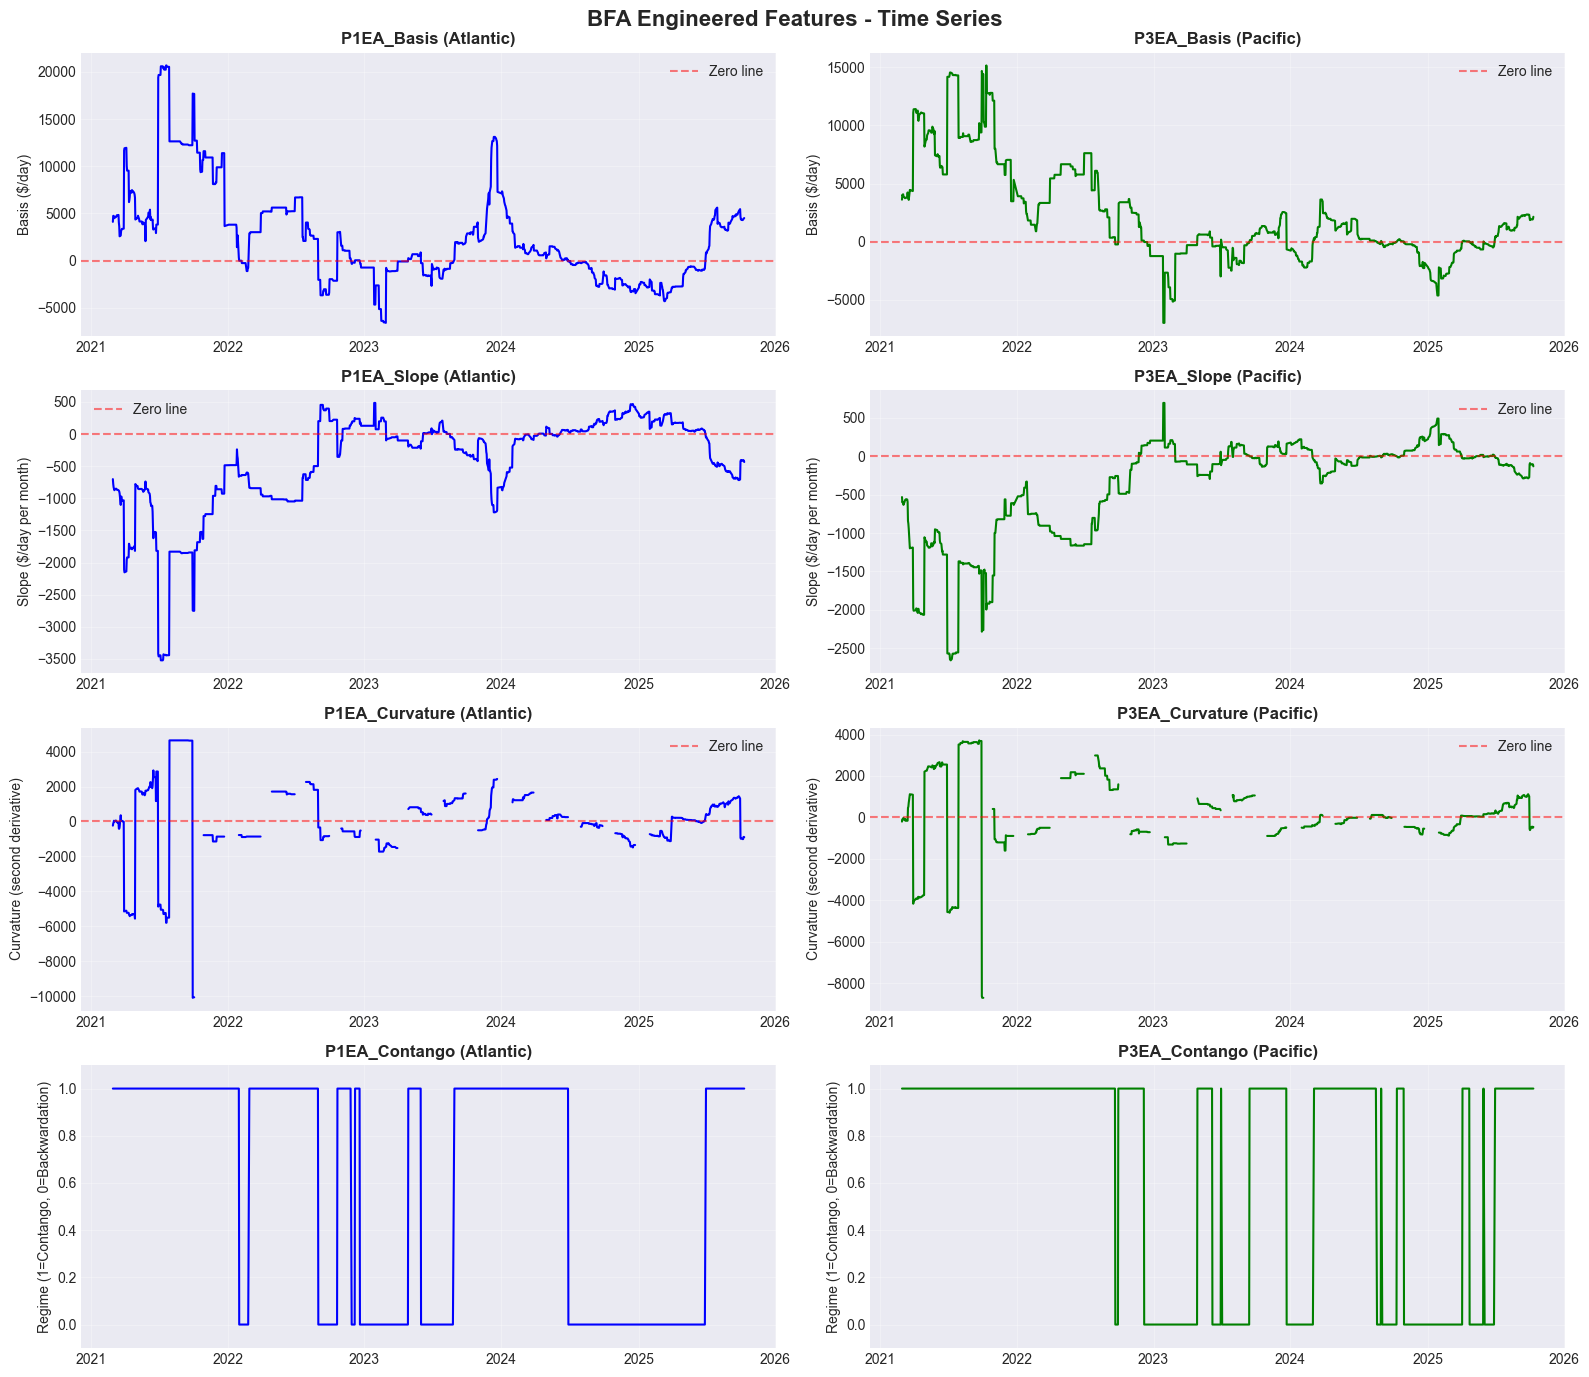


P1EA (Atlantic) BFA Features - Summary:
         P1EA_Basis   P1EA_Slope  P1EA_Curvature  P1EA_Contango
count   1153.000000  1153.000000      861.000000    1153.000000
mean    2434.260480  -427.685055      136.802555       0.601908
std     5037.356993   748.247604     1962.660476       0.489717
min    -6601.000000 -3521.894591   -10083.000000       0.000000
25%    -1000.750000  -841.791956     -847.000000       0.000000
50%     1243.000000   -99.633842       88.500000       1.000000
75%     4618.500000    82.932039     1272.000000       1.000000
max    20687.000000   485.611111     4638.500000       1.000000


P3EA (Pacific) BFA Features - Summary:
         P3EA_Basis   P3EA_Slope  P3EA_Curvature  P3EA_Contango
count   1153.000000  1153.000000      861.000000    1153.000000
mean    2262.109858  -393.354631      118.250871       0.651344
std     4074.213948   644.114769     1679.292269       0.476752
min    -6994.333333 -2659.570042    -8712.500000       0.000000
25%     -323.500000  -

In [12]:
# Visualize BFA engineered features
fig, axes = plt.subplots(4, 2, figsize=(16, 14))
fig.suptitle('BFA Engineered Features - Time Series', fontsize=16, fontweight='bold')

# P1EA (Atlantic) features
ax = axes[0, 0]
ax.plot(bfa_p1_features['Date'], bfa_p1_features['P1EA_Basis'], linewidth=1.5, color='blue')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero line')
ax.set_title('P1EA_Basis (Atlantic)', fontsize=12, fontweight='bold')
ax.set_ylabel('Basis ($/day)')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1, 0]
ax.plot(bfa_p1_features['Date'], bfa_p1_features['P1EA_Slope'], linewidth=1.5, color='blue')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero line')
ax.set_title('P1EA_Slope (Atlantic)', fontsize=12, fontweight='bold')
ax.set_ylabel('Slope ($/day per month)')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[2, 0]
ax.plot(bfa_p1_features['Date'], bfa_p1_features['P1EA_Curvature'], linewidth=1.5, color='blue')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero line')
ax.set_title('P1EA_Curvature (Atlantic)', fontsize=12, fontweight='bold')
ax.set_ylabel('Curvature (second derivative)')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[3, 0]
ax.plot(bfa_p1_features['Date'], bfa_p1_features['P1EA_Contango'], linewidth=1.5, color='blue')
ax.set_title('P1EA_Contango (Atlantic)', fontsize=12, fontweight='bold')
ax.set_ylabel('Regime (1=Contango, 0=Backwardation)')
ax.set_ylim(-0.1, 1.1)
ax.grid(True, alpha=0.3)

# P3EA (Pacific) features
ax = axes[0, 1]
ax.plot(bfa_p3_features['Date'], bfa_p3_features['P3EA_Basis'], linewidth=1.5, color='green')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero line')
ax.set_title('P3EA_Basis (Pacific)', fontsize=12, fontweight='bold')
ax.set_ylabel('Basis ($/day)')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1, 1]
ax.plot(bfa_p3_features['Date'], bfa_p3_features['P3EA_Slope'], linewidth=1.5, color='green')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero line')
ax.set_title('P3EA_Slope (Pacific)', fontsize=12, fontweight='bold')
ax.set_ylabel('Slope ($/day per month)')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[2, 1]
ax.plot(bfa_p3_features['Date'], bfa_p3_features['P3EA_Curvature'], linewidth=1.5, color='green')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero line')
ax.set_title('P3EA_Curvature (Pacific)', fontsize=12, fontweight='bold')
ax.set_ylabel('Curvature (second derivative)')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[3, 1]
ax.plot(bfa_p3_features['Date'], bfa_p3_features['P3EA_Contango'], linewidth=1.5, color='green')
ax.set_title('P3EA_Contango (Pacific)', fontsize=12, fontweight='bold')
ax.set_ylabel('Regime (1=Contango, 0=Backwardation)')
ax.set_ylim(-0.1, 1.1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nP1EA (Atlantic) BFA Features - Summary:")
print("="*80)
print(bfa_p1_features[['P1EA_Basis', 'P1EA_Slope', 'P1EA_Curvature', 'P1EA_Contango']].describe())

print("\n\nP3EA (Pacific) BFA Features - Summary:")
print("="*80)
print(bfa_p3_features[['P3EA_Basis', 'P3EA_Slope', 'P3EA_Curvature', 'P3EA_Contango']].describe())

In [13]:
# Apply forward fill (RA-LOCF) with proper temporal alignment
# Monthly data already respects 15-day publication lag (shifted before merge)
# Weekly and daily data have 0-day lag

print("Applying forward fill (RA-LOCF)...")
print("="*80)

# Identify monthly features for special handling
monthly_features = list(clx_monthly_shifted.columns)
monthly_features.remove('Date')

# Forward fill ALL features (main operation)
ra_locf_df = master_df.copy()
for col in ra_locf_df.columns:
    if col != 'Date':
        ra_locf_df[col] = ra_locf_df[col].ffill()

print(f"After forward fill: {ra_locf_df.isnull().sum().sum()} missing values")

# ONLY for monthly features: backfill the FIRST 15 days (before first monthly publication)
# This handles the period March 1-15, 2021 before March 2021 data published on April 15
first_monthly_pub_date = pd.Timestamp('2021-04-15')  # March 2021 data published April 15
initial_period_mask = ra_locf_df['Date'] < first_monthly_pub_date

for col in monthly_features:
    if col in ra_locf_df.columns:
        # Backfill only for the initial period before first monthly publication
        ra_locf_df.loc[initial_period_mask, col] = ra_locf_df.loc[initial_period_mask, col].bfill()

print(f"After backfilling first 15 days for monthly features: {ra_locf_df.isnull().sum().sum()} missing values")

# Quality check: Drop rows with excessive NaNs (>20% of features missing)
# This removes bad quality rows without losing data from features that started later
total_features = len(ra_locf_df.columns) - 1  # Exclude Date
nan_threshold = int(total_features * 0.2)  # 20% threshold

nan_counts_per_row = ra_locf_df.drop('Date', axis=1).isnull().sum(axis=1)
rows_to_drop = nan_counts_per_row > nan_threshold

clean_df = ra_locf_df[~rows_to_drop].copy()

rows_dropped = rows_to_drop.sum()
print(f"\n[QUALITY CHECK] Rows with >{nan_threshold} NaNs (>20%): {rows_dropped} dropped")
print(f"[CLEANED] Final dataset: {clean_df.shape}")
print(f"Date range: {clean_df['Date'].min().date()} to {clean_df['Date'].max().date()}")
print(f"Total days: {len(clean_df)} days (~{len(clean_df)/365:.1f} years)")
print(f"Remaining NaN values: {clean_df.isnull().sum().sum()}")

# Show which features still have NaN (features that started later)
remaining_nans = clean_df.drop('Date', axis=1).isnull().sum()
remaining_nans = remaining_nans[remaining_nans > 0].sort_values(ascending=False)
if len(remaining_nans) > 0:
    print(f"\nFeatures with remaining NaN (started later):")
    for feat, count in remaining_nans.head(10).items():
        pct = (count / len(clean_df)) * 100
        print(f"  - {feat}: {count} missing ({pct:.1f}%)")

print("="*80)

Applying forward fill (RA-LOCF)...
After forward fill: 3271 missing values
After backfilling first 15 days for monthly features: 3007 missing values

[QUALITY CHECK] Rows with >13 NaNs (>20%): 0 dropped
[CLEANED] Final dataset: (1154, 68)
Date range: 2021-03-01 to 2025-10-13
Total days: 1154 days (~3.2 years)
Remaining NaN values: 3007

Features with remaining NaN (started later):
  - Average Kamsarmax c. 2020s-built (Eco) Earnings - $/day: 957 missing (82.9%)
  - Average Capesize 2020s-built (Eco) Earnings - $/day: 957 missing (82.9%)
  - CO2 EUA Price ($), Front Month future, weekly average - $/tonne CO2: 460 missing (39.9%)
  - ODV_P5TC: 314 missing (27.2%)
  - P7-TCE: 210 missing (18.2%)
  - PDDC: 31 missing (2.7%)
  - PDIC: 31 missing (2.7%)
  - PDOPEX: 31 missing (2.7%)
  - 5 Year Timecharter Rate 82,000 dwt Bulkcarrier (Atlantic Region) - $/day: 4 missing (0.3%)
  - 1 Year Timecharter Rate 82,000 dwt Bulkcarrier (Pacific Region) - $/day: 4 missing (0.3%)


In [14]:
# P1A_82 (Atlantic) ML Features (49)
p1a_ml_features = [
    # Cost (2)
    'VLSFO', 'MGO',
    # Market Fundamentals - Baltic Indices (5)
    'BDI', 'BPI', 'BCI', 'C8', 'P4_82',
    # Market Fundamentals - Operating Costs (7)
    'PDOPEX', 'PDDC', 'PDIC', 'PDISRA', 'PDITC', 'PDRRI', 'PDRVI',
    # Market Fundamentals - FFA (5)
    'FFADVPmx_T', 'FFAPmxOI', 'FFADV_P5TC', 'FFADV_T',
    # Market Fundamentals - Options (3)
    'ODV_P4TC', 'ODV_P5TC', 'ODV_T',
    # Market Expectations - BFA (4)
    'P1EA_Basis', 'P1EA_Slope', 'P1EA_Curvature', 'P1EA_Contango',
    # Supply - Panamax (9)
    'Panamax Bulker - % Idle - DWT million',
    'Panamax Bulker Average Speed - Knots',
    'Average Kamsarmax c. 2020s-built (Eco) Earnings - $/day',
    'Panamax Bulkcarrier Fleet Development - DWT million',
    'Panamax Bulkcarrier Demolition - DWT',
    'Panamax Bulkcarrier Deliveries - DWT',
    'Panamax Bulker Contracting - DWT',
    'Panamax Fleet Growth % Yr/Yr',
    'Panamax Orderbook % Fleet',
    # Supply - Capesize (9)
    'Capesize Bulker - % Idle - DWT million',
    'Average Capesize 2020s-built (Eco) Earnings - $/day',
    'Capesize Bulkcarrier Demolition - DWT',
    'Capesize Bulkcarrier Deliveries - DWT',
    'Capesize Bulker Contracting - DWT',
    'Capesize Fleet Growth % Yr/Yr',
    'Capesize Orderbook % Fleet',
    'CO2 EUA Price ($), Front Month future, weekly average - $/tonne CO2',
    'Monthly Global Seaborne Dry Bulk Trade Indicator % Yr/Yr',
    # Demand - Atlantic specific (5)
    'Atlantic Region Port Calls - Deep Sea Cargo Vessels, 7 day avg. - Number',
    '1 Year Timecharter Rate 82,000 dwt Bulkcarrier (Atlantic Region) - $/day',
    '5 Year Timecharter Rate 82,000 dwt Bulkcarrier (Atlantic Region) - $/day',
    'Atlantic Region Industrial Production Growth % Yr/Yr',
    'Monthly Global Seaborne Grain Trade Indicator % Yr/Yr',
    # Additional Market feature
    'P7-TCE'
]

# P1A_82 (Atlantic) ARIMAX Core (12)
p1a_arimax_core = [
    'Panamax Bulker - % Idle - DWT million',
    'Panamax Orderbook % Fleet',
    'Panamax Fleet Growth % Yr/Yr',
    'Atlantic Region Industrial Production Growth % Yr/Yr',
    'Monthly Global Seaborne Grain Trade Indicator % Yr/Yr',
    'Atlantic Region Port Calls - Deep Sea Cargo Vessels, 7 day avg. - Number',
    'VLSFO',
    'PDOPEX',
    'P1EA_Basis',
    'P1EA_Slope',
    'BPI',
    'FFADVPmx_T'
]

# P3A_82 (Pacific) ML Features (58)
p3a_ml_features = [
    # Cost (2) - same as P1A
    'VLSFO', 'MGO',
    # Market Fundamentals (20) - same as P1A
    'BDI', 'BPI', 'BCI', 'C8', 'P4_82',
    'PDOPEX', 'PDDC', 'PDIC', 'PDISRA', 'PDITC', 'PDRRI', 'PDRVI',
    'FFADVPmx_T', 'FFAPmxOI', 'FFADV_P5TC', 'FFADV_T',
    'ODV_P4TC', 'ODV_P5TC', 'ODV_T',
    # Market Expectations - BFA (4) - P3EA based
    'P3EA_Basis', 'P3EA_Slope', 'P3EA_Curvature', 'P3EA_Contango',
    # Supply (18) - same as P1A
    'Panamax Bulker - % Idle - DWT million',
    'Panamax Bulker Average Speed - Knots',
    'Average Kamsarmax c. 2020s-built (Eco) Earnings - $/day',
    'Panamax Bulkcarrier Fleet Development - DWT million',
    'Panamax Bulkcarrier Demolition - DWT',
    'Panamax Bulkcarrier Deliveries - DWT',
    'Panamax Bulker Contracting - DWT',
    'Panamax Fleet Growth % Yr/Yr',
    'Panamax Orderbook % Fleet',
    'Capesize Bulker - % Idle - DWT million',
    'Average Capesize 2020s-built (Eco) Earnings - $/day',
    'Capesize Bulkcarrier Demolition - DWT',
    'Capesize Bulkcarrier Deliveries - DWT',
    'Capesize Bulker Contracting - DWT',
    'Capesize Fleet Growth % Yr/Yr',
    'Capesize Orderbook % Fleet',
    'CO2 EUA Price ($), Front Month future, weekly average - $/tonne CO2',
    'Monthly Global Seaborne Dry Bulk Trade Indicator % Yr/Yr',
    # Demand - Pacific specific (14)
    'Pacific Region (excl. China) Port Calls - Deep Sea Cargo Vessels, 7 day avg. - GT million',
    'China P.R. Port Calls - Bulkcarriers, 7 day average - DWT',
    '1 Year Timecharter Rate 82,000 dwt Bulkcarrier (Pacific Region) - $/day',
    '5 Year Timecharter Rate 82,000 dwt Bulkcarrier (Pacific Region) - $/day',
    'Pacific Region Industrial Production Growth % Yr/Yr',
    'Industrial Production  China % Yr/Yr',
    'Industrial Production  India % Yr/Yr',
    'Australia Seaborne Iron Ore Exports - Million Tonnes',
    'Brazil Seaborne Iron Ore Exports - Million Tonnes',
    'China Seaborne Iron Ore Imports - Million Tonnes',
    'South Korea Seaborne Iron Ore Imports - Million Tonnes',
    'Japan Seaborne Iron Ore Imports - Million Tonnes',
    'Monthly Global Seaborne Iron Ore Trade Indicator % Yr/Yr',
    'Monthly Global Seaborne Coal Trade Indicator % Yr/Yr'
]

# P3A_82 (Pacific) ARIMAX Core (12)
p3a_arimax_core = [
    'Panamax Bulker - % Idle - DWT million',
    'Panamax Orderbook % Fleet',
    'Panamax Fleet Growth % Yr/Yr',
    'Pacific Region Industrial Production Growth % Yr/Yr',
    'China Seaborne Iron Ore Imports - Million Tonnes',
    'China P.R. Port Calls - Bulkcarriers, 7 day average - DWT',
    'VLSFO',
    'PDOPEX',
    'P3EA_Basis',
    'P3EA_Slope',
    'BPI',
    'FFADVPmx_T'
]

print("Feature lists defined:")
print(f"P1A ML: {len(p1a_ml_features)} features")
print(f"P1A ARIMAX: {len(p1a_arimax_core)} features")
print(f"P3A ML: {len(p3a_ml_features)} features")
print(f"P3A ARIMAX: {len(p3a_arimax_core)} features")

Feature lists defined:
P1A ML: 49 features
P1A ARIMAX: 12 features
P3A ML: 57 features
P3A ARIMAX: 12 features


In [15]:
# Create P1A ML features
p1a_ml_df = clean_df[['Date'] + p1a_ml_features].copy()
p1a_ml_df.to_csv(f'{OUTPUT_DIR}p1a_ml_features.csv', index=False)
print(f"[SAVED] P1A ML features: {p1a_ml_df.shape} → {OUTPUT_DIR}p1a_ml_features.csv")

# Create P1A ARIMAX core
p1a_arimax_df = clean_df[['Date'] + p1a_arimax_core].copy()
p1a_arimax_df.to_csv(f'{OUTPUT_DIR}p1a_arimax_core.csv', index=False)
print(f"[SAVED] P1A ARIMAX core: {p1a_arimax_df.shape} → {OUTPUT_DIR}p1a_arimax_core.csv")

# Create P3A ML features
p3a_ml_df = clean_df[['Date'] + p3a_ml_features].copy()
p3a_ml_df.to_csv(f'{OUTPUT_DIR}p3a_ml_features.csv', index=False)
print(f"[SAVED] P3A ML features: {p3a_ml_df.shape} → {OUTPUT_DIR}p3a_ml_features.csv")

# Create P3A ARIMAX core
p3a_arimax_df = clean_df[['Date'] + p3a_arimax_core].copy()
p3a_arimax_df.to_csv(f'{OUTPUT_DIR}p3a_arimax_core.csv', index=False)
print(f"[SAVED] P3A ARIMAX core: {p3a_arimax_df.shape} → {OUTPUT_DIR}p3a_arimax_core.csv")

# Save targets (align dates with clean_df)
targets_clean = pd.merge(clean_df[['Date']], targets_df, on='Date', how='inner')
targets_clean.to_csv(f'{OUTPUT_DIR}targets.csv', index=False)
print(f"[SAVED] Targets: {targets_clean.shape} → {OUTPUT_DIR}targets.csv")

print("\n" + "="*80)
print("All model-ready feature sets created successfully!")
print("="*80)

[SAVED] P1A ML features: (1154, 50) → data/processed/p1a_ml_features.csv
[SAVED] P1A ARIMAX core: (1154, 13) → data/processed/p1a_arimax_core.csv
[SAVED] P3A ML features: (1154, 58) → data/processed/p3a_ml_features.csv
[SAVED] P3A ARIMAX core: (1154, 13) → data/processed/p3a_arimax_core.csv
[SAVED] Targets: (1154, 3) → data/processed/targets.csv

All model-ready feature sets created successfully!


In [16]:
# Create comprehensive feature metadata
metadata_records = []

# Define feature lists by frequency for metadata
daily_features = list(bunker_df.columns[1:]) + list(baltic_features[1:]) + list(clx_daily.columns[1:]) + list(bfa_engineered.columns[1:])
weekly_features = list(clx_weekly.columns[1:])
monthly_features = list(clx_monthly.columns[1:])


# Helper function to determine frequency
def get_frequency(feature_name):
    if feature_name in daily_features:
        return 'Daily'
    elif feature_name in weekly_features:
        return 'Weekly'
    elif feature_name in monthly_features:
        return 'Monthly'
    else:
        return 'Unknown'

# Helper function to determine source
def get_source(feature_name):
    if feature_name in ['VLSFO', 'MGO']:
        return 'Ship & Bunker'
    elif feature_name in list(baltic_features[1:]):
        return 'Baltic Exchange'
    elif 'P1EA' in feature_name or 'P3EA' in feature_name:
        return 'BFA (Engineered)'
    else:
        return 'Clarksons'

# Helper function to determine category
def get_category(feature_name):
    if feature_name in ['VLSFO', 'MGO']:
        return 'Cost'
    elif 'Idle' in feature_name or 'Fleet' in feature_name or 'Orderbook' in feature_name or 'Contracting' in feature_name or 'Demolition' in feature_name or 'Deliveries' in feature_name or 'Speed' in feature_name:
        return 'Supply'
    elif 'Port Calls' in feature_name or 'Production' in feature_name or 'Trade' in feature_name or 'Imports' in feature_name or 'Exports' in feature_name:
        return 'Demand'
    else:
        return 'Market'

# Compile all unique features
all_features = set(p1a_ml_features + p3a_ml_features)

for feature in sorted(all_features):
    # Determine model usage
    in_p1a_ml = feature in p1a_ml_features
    in_p1a_arimax = feature in p1a_arimax_core
    in_p3a_ml = feature in p3a_ml_features
    in_p3a_arimax = feature in p3a_arimax_core
    
    model_usage = []
    if in_p1a_ml:
        model_usage.append('P1A_ML')
    if in_p1a_arimax:
        model_usage.append('P1A_ARIMAX')
    if in_p3a_ml:
        model_usage.append('P3A_ML')
    if in_p3a_arimax:
        model_usage.append('P3A_ARIMAX')
    
    # Determine engineering
    if '_Basis' in feature:
        engineering = 'BFA_Basis'
    elif '_Slope' in feature:
        engineering = 'BFA_Slope'
    elif '_Curvature' in feature:
        engineering = 'BFA_Curvature'
    elif '_Contango' in feature:
        engineering = 'BFA_Contango'
    else:
        engineering = 'None'
    
    # Determine publication lag
    freq = get_frequency(feature)
    if freq == 'Monthly':
        pub_lag = 15
    else:
        pub_lag = 0
    
    metadata_records.append({
        'FeatureName': feature,
        'Source': get_source(feature),
        'Category': get_category(feature),
        'Frequency': freq,
        'PublicationLag': pub_lag,
        'Engineering': engineering,
        'ModelUsage': ', '.join(model_usage)
    })

metadata_df = pd.DataFrame(metadata_records)
metadata_df.to_csv(f'{OUTPUT_DIR}feature_metadata.csv', index=False)

print(f"[SAVED] Feature metadata: {metadata_df.shape} → {OUTPUT_DIR}feature_metadata.csv")
print(f"\nMetadata sample:")
print(metadata_df.head(10))

[SAVED] Feature metadata: (67, 7) → data/processed/feature_metadata.csv

Metadata sample:
                                         FeatureName           Source Category Frequency  PublicationLag Engineering          ModelUsage
0  1 Year Timecharter Rate 82,000 dwt Bulkcarrier...        Clarksons   Market    Weekly               0        None              P1A_ML
1  1 Year Timecharter Rate 82,000 dwt Bulkcarrier...        Clarksons   Market    Weekly               0        None              P3A_ML
2  5 Year Timecharter Rate 82,000 dwt Bulkcarrier...        Clarksons   Market    Weekly               0        None              P1A_ML
3  5 Year Timecharter Rate 82,000 dwt Bulkcarrier...        Clarksons   Market    Weekly               0        None              P3A_ML
4  Atlantic Region Industrial Production Growth %...        Clarksons   Demand   Monthly              15        None  P1A_ML, P1A_ARIMAX
5  Atlantic Region Port Calls - Deep Sea Cargo Ve...        Clarksons   Demand     Daily

In [17]:
print("P1A ARIMAX Core Features - Summary Statistics:")
print("="*80)
print(p1a_arimax_df.describe().T)

print("\n\nP3A ARIMAX Core Features - Summary Statistics:")
print("="*80)
print(p3a_arimax_df.describe().T)

P1A ARIMAX Core Features - Summary Statistics:
                                                     count                           mean                  min                  25%                  50%                  75%                  max          std
Date                                                  1154  2023-06-22 19:11:45.025996544  2021-03-01 00:00:00  2022-04-26 06:00:00  2023-06-26 12:00:00  2024-08-18 06:00:00  2025-10-13 00:00:00          NaN
Panamax Bulker - % Idle - DWT million               1154.0                       6.347227                  4.0                  5.5                  6.2                  7.1                  8.9     1.106606
Panamax Orderbook % Fleet                           1154.0                       11.92091                 7.94                 9.97                10.97                14.46                15.88     2.491644
Panamax Fleet Growth % Yr/Yr                        1154.0                       3.545494                  2.9           

In [18]:
print("Missing Values in ARIMAX Core Features:")
print("="*80)
print(f"P1A: {p1a_arimax_df.isnull().sum().sum()} total missing values")
print(f"P3A: {p3a_arimax_df.isnull().sum().sum()} total missing values")
print("\nAll features should have zero missing values after RA-LOCF and cleaning.")

Missing Values in ARIMAX Core Features:
P1A: 31 total missing values
P3A: 31 total missing values

All features should have zero missing values after RA-LOCF and cleaning.


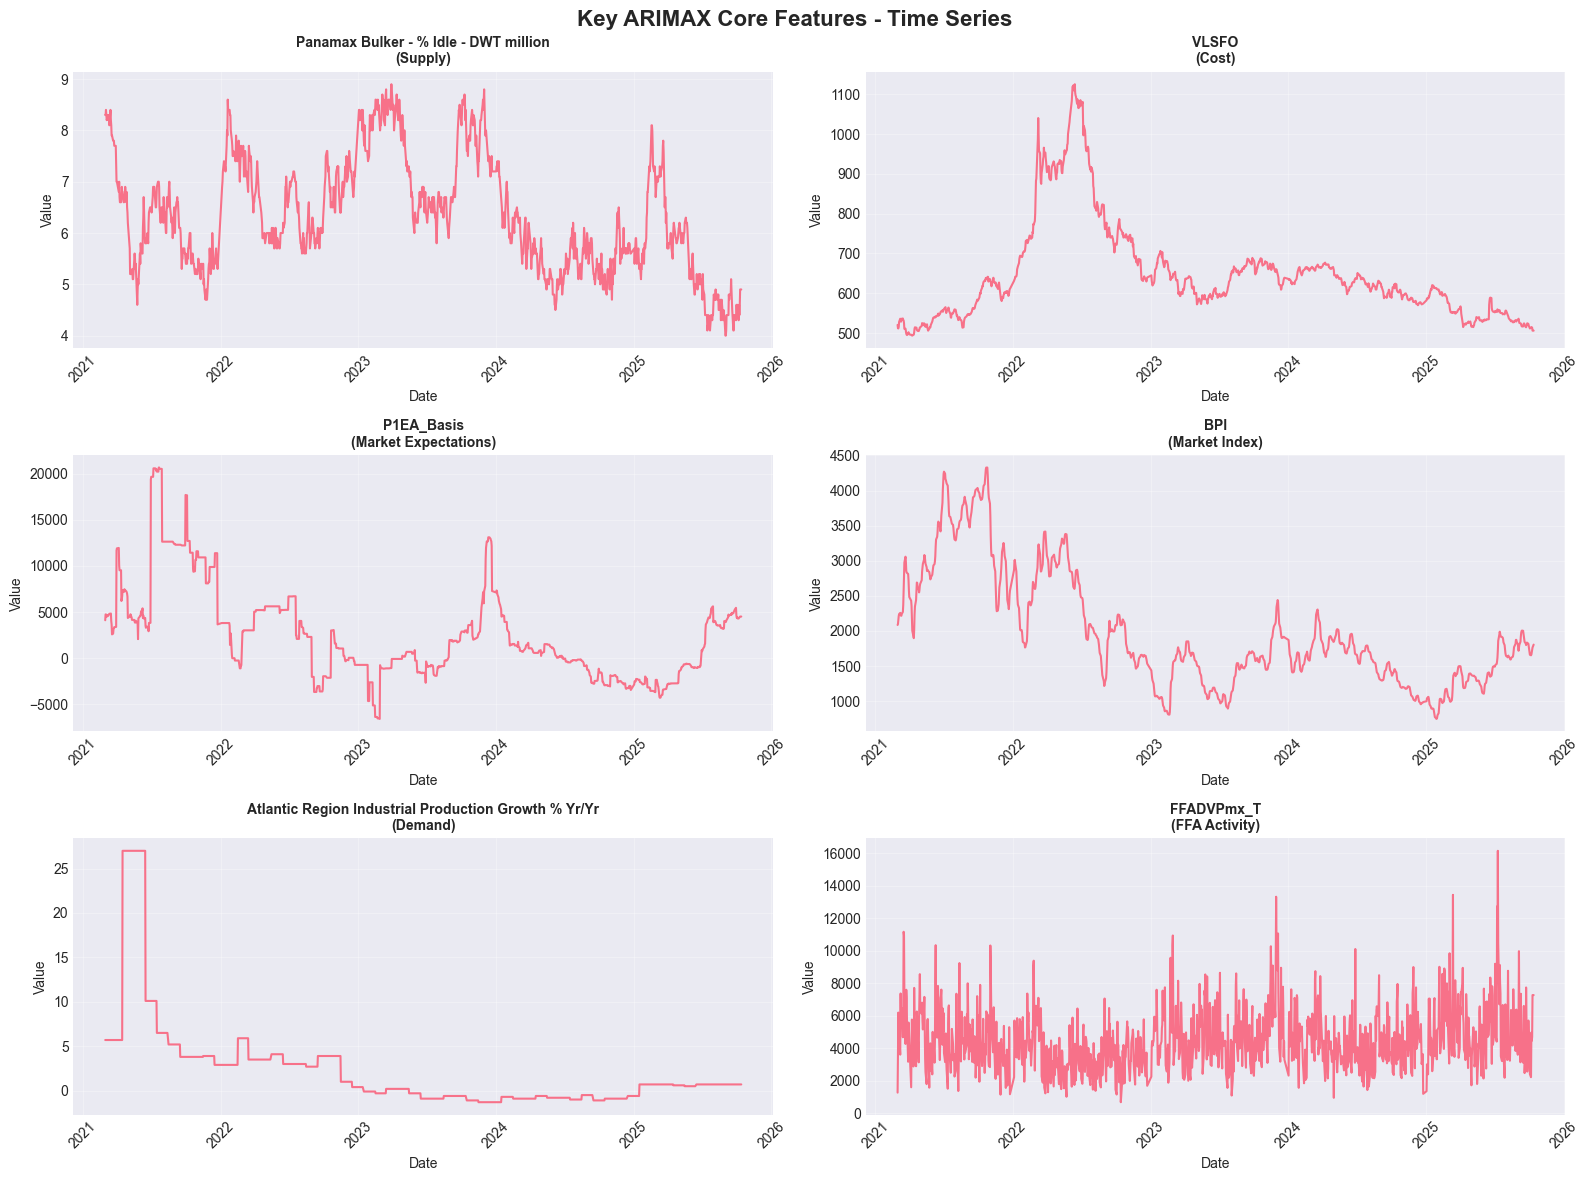

In [19]:
# Plot key ARIMAX features over time
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Key ARIMAX Core Features - Time Series', fontsize=16, fontweight='bold')

# P1A features
features_to_plot = [
    ('Panamax Bulker - % Idle - DWT million', 'Supply'),
    ('VLSFO', 'Cost'),
    ('P1EA_Basis', 'Market Expectations'),
    ('BPI', 'Market Index'),
    ('Atlantic Region Industrial Production Growth % Yr/Yr', 'Demand'),
    ('FFADVPmx_T', 'FFA Activity')
]

for idx, (feature, category) in enumerate(features_to_plot):
    ax = axes[idx // 2, idx % 2]
    ax.plot(p1a_arimax_df['Date'], p1a_arimax_df[feature], linewidth=1.5)
    ax.set_title(f'{feature}\n({category})', fontsize=10, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

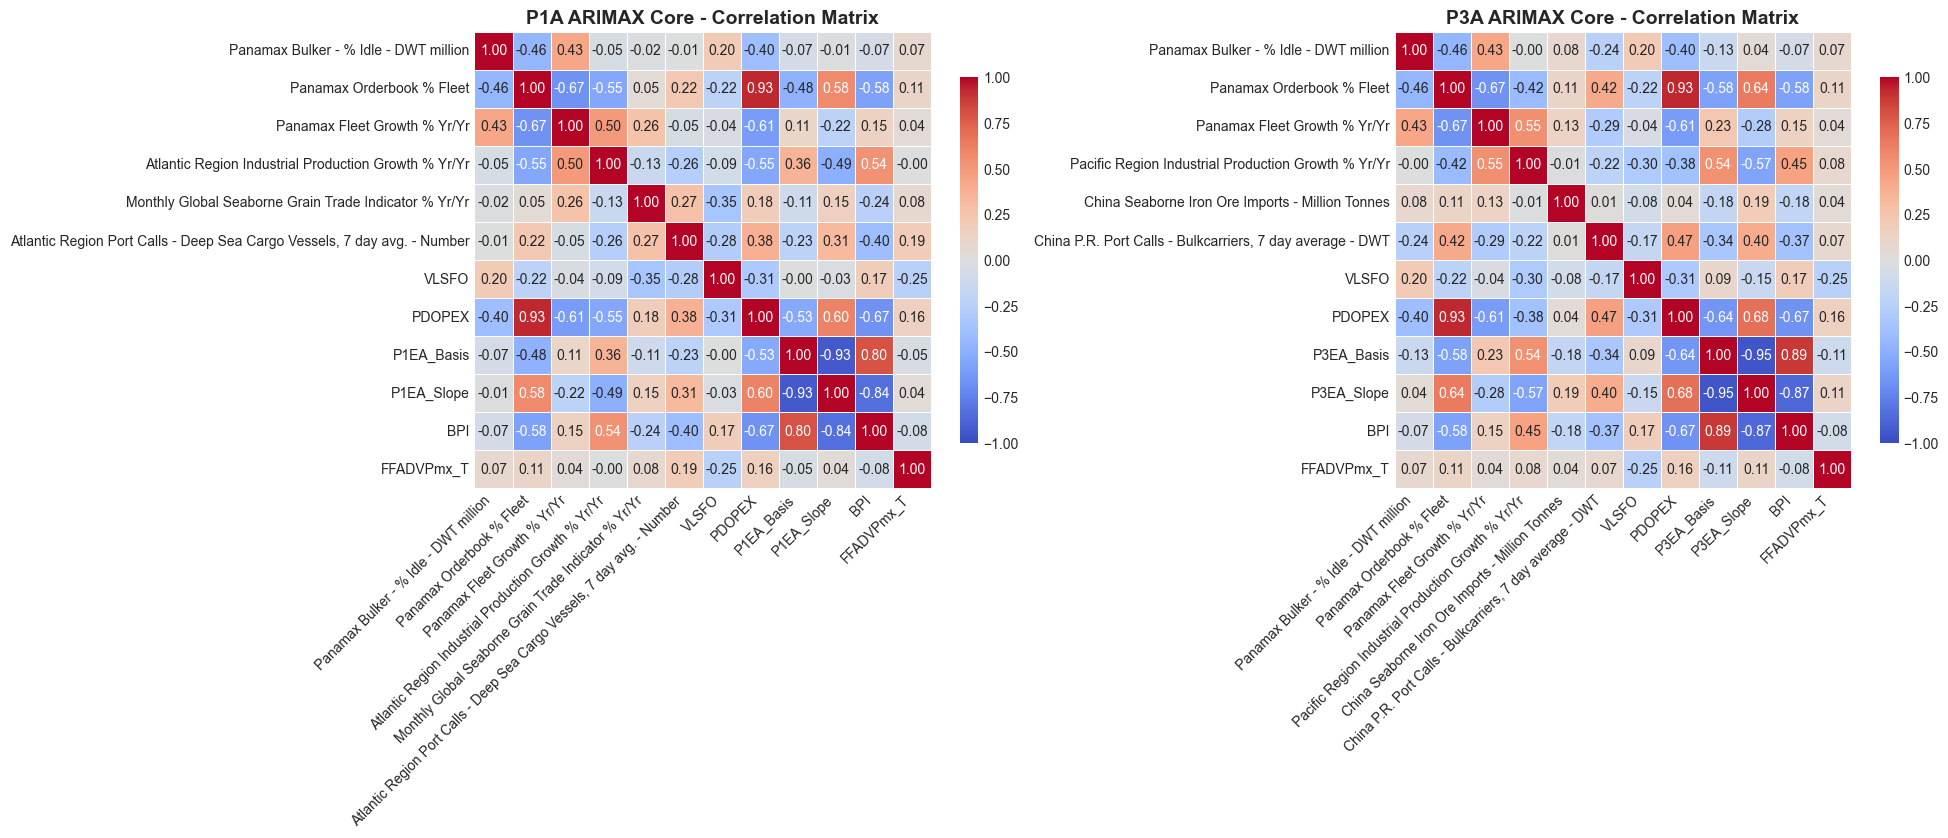


High Correlations (|r| > 0.7) in P1A ARIMAX Core:
                   Feature 1   Feature 2  Correlation
0  Panamax Orderbook % Fleet      PDOPEX     0.934782
1                 P1EA_Basis  P1EA_Slope    -0.934650
2                 P1EA_Basis         BPI     0.801652
3                 P1EA_Slope         BPI    -0.843590

High Correlations (|r| > 0.7) in P3A ARIMAX Core:
                   Feature 1   Feature 2  Correlation
0  Panamax Orderbook % Fleet      PDOPEX     0.934782
1                 P3EA_Basis  P3EA_Slope    -0.954274
2                 P3EA_Basis         BPI     0.886381
3                 P3EA_Slope         BPI    -0.872782


In [20]:
# Compute correlation matrices
p1a_corr = p1a_arimax_df.drop('Date', axis=1).corr()
p3a_corr = p3a_arimax_df.drop('Date', axis=1).corr()

# Plot correlation heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(p1a_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=ax1, vmin=-1, vmax=1)
ax1.set_title('P1A ARIMAX Core - Correlation Matrix', fontsize=14, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

sns.heatmap(p3a_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=ax2, vmin=-1, vmax=1)
ax2.set_title('P3A ARIMAX Core - Correlation Matrix', fontsize=14, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Identify high correlations
print("\nHigh Correlations (|r| > 0.7) in P1A ARIMAX Core:")
print("="*80)
high_corr_p1a = []
for i in range(len(p1a_corr.columns)):
    for j in range(i+1, len(p1a_corr.columns)):
        if abs(p1a_corr.iloc[i, j]) > 0.7:
            high_corr_p1a.append({
                'Feature 1': p1a_corr.columns[i],
                'Feature 2': p1a_corr.columns[j],
                'Correlation': p1a_corr.iloc[i, j]
            })
if high_corr_p1a:
    print(pd.DataFrame(high_corr_p1a))
else:
    print("No high correlations found.")

print("\nHigh Correlations (|r| > 0.7) in P3A ARIMAX Core:")
print("="*80)
high_corr_p3a = []
for i in range(len(p3a_corr.columns)):
    for j in range(i+1, len(p3a_corr.columns)):
        if abs(p3a_corr.iloc[i, j]) > 0.7:
            high_corr_p3a.append({
                'Feature 1': p3a_corr.columns[i],
                'Feature 2': p3a_corr.columns[j],
                'Correlation': p3a_corr.iloc[i, j]
            })
if high_corr_p3a:
    print(pd.DataFrame(high_corr_p3a))
else:
    print("No high correlations found.")

In [21]:
def test_stationarity(series, name):
    """
    Perform ADF and KPSS tests for stationarity
    """
    # Remove NaN values
    series_clean = series.dropna()
    
    # ADF test
    adf_result = adfuller(series_clean, autolag='AIC')
    adf_statistic = adf_result[0]
    adf_pvalue = adf_result[1]
    adf_conclusion = 'Stationary' if adf_pvalue < 0.05 else 'Non-Stationary'
    
    # KPSS test
    kpss_result = kpss(series_clean, regression='ct', nlags='auto')
    kpss_statistic = kpss_result[0]
    kpss_pvalue = kpss_result[1]
    kpss_conclusion = 'Stationary' if kpss_pvalue > 0.05 else 'Non-Stationary'
    
    return {
        'Feature': name,
        'ADF Statistic': adf_statistic,
        'ADF p-value': adf_pvalue,
        'ADF Conclusion': adf_conclusion,
        'KPSS Statistic': kpss_statistic,
        'KPSS p-value': kpss_pvalue,
        'KPSS Conclusion': kpss_conclusion
    }

print("Stationarity Testing for P1A ARIMAX Core Features:")
print("="*80)
p1a_stationarity = []
for col in p1a_arimax_core:
    result = test_stationarity(p1a_arimax_df[col], col)
    p1a_stationarity.append(result)

p1a_stat_df = pd.DataFrame(p1a_stationarity)
print(p1a_stat_df[['Feature', 'ADF p-value', 'ADF Conclusion', 'KPSS p-value', 'KPSS Conclusion']])

print("\n\nStationarity Testing for P3A ARIMAX Core Features:")
print("="*80)
p3a_stationarity = []
for col in p3a_arimax_core:
    result = test_stationarity(p3a_arimax_df[col], col)
    p3a_stationarity.append(result)

p3a_stat_df = pd.DataFrame(p3a_stationarity)
print(p3a_stat_df[['Feature', 'ADF p-value', 'ADF Conclusion', 'KPSS p-value', 'KPSS Conclusion']])

Stationarity Testing for P1A ARIMAX Core Features:
                                              Feature  ADF p-value  ADF Conclusion  KPSS p-value KPSS Conclusion
0               Panamax Bulker - % Idle - DWT million     0.016010      Stationary          0.01  Non-Stationary
1                           Panamax Orderbook % Fleet     0.644711  Non-Stationary          0.01  Non-Stationary
2                        Panamax Fleet Growth % Yr/Yr     0.133964  Non-Stationary          0.01  Non-Stationary
3   Atlantic Region Industrial Production Growth %...     0.082032  Non-Stationary          0.01  Non-Stationary
4   Monthly Global Seaborne Grain Trade Indicator ...     0.017648      Stationary          0.01  Non-Stationary
5   Atlantic Region Port Calls - Deep Sea Cargo Ve...     0.142210  Non-Stationary          0.01  Non-Stationary
6                                               VLSFO     0.264874  Non-Stationary          0.01  Non-Stationary
7                                            

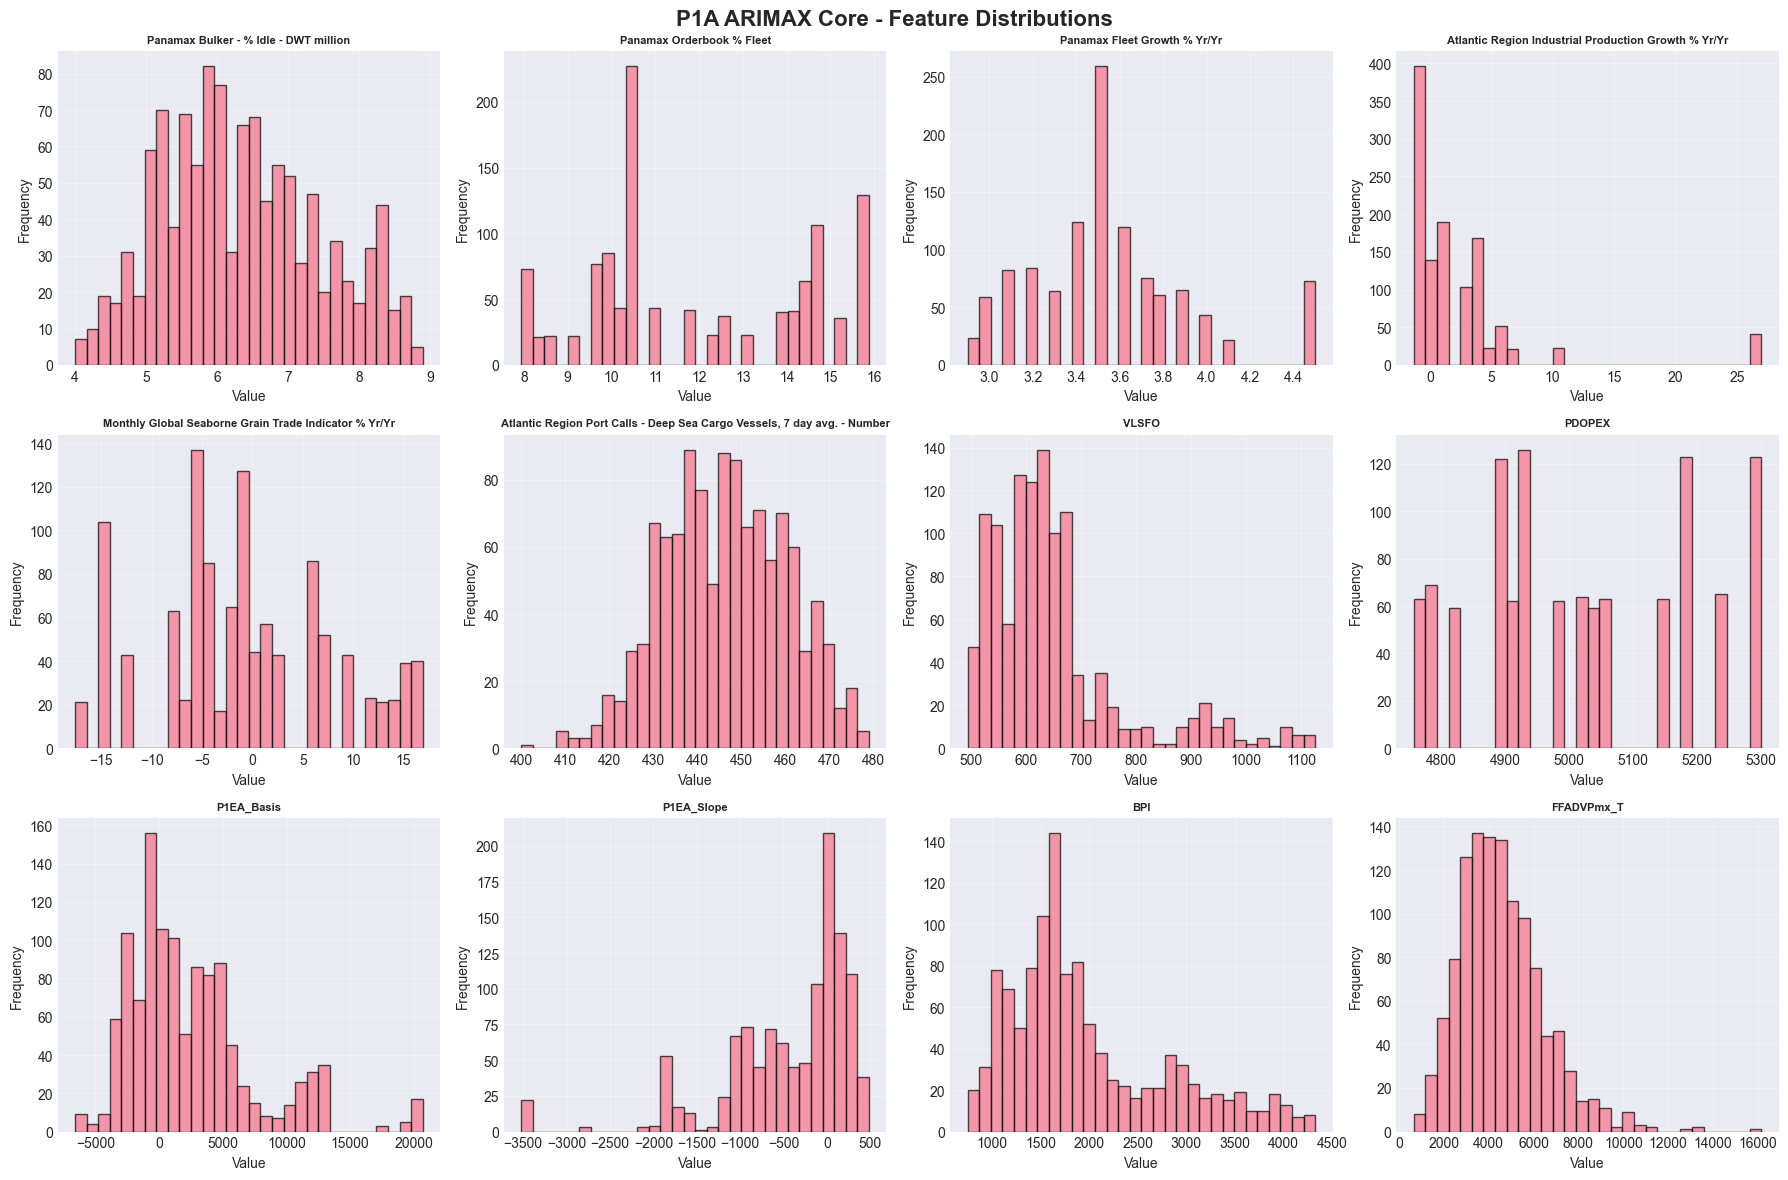

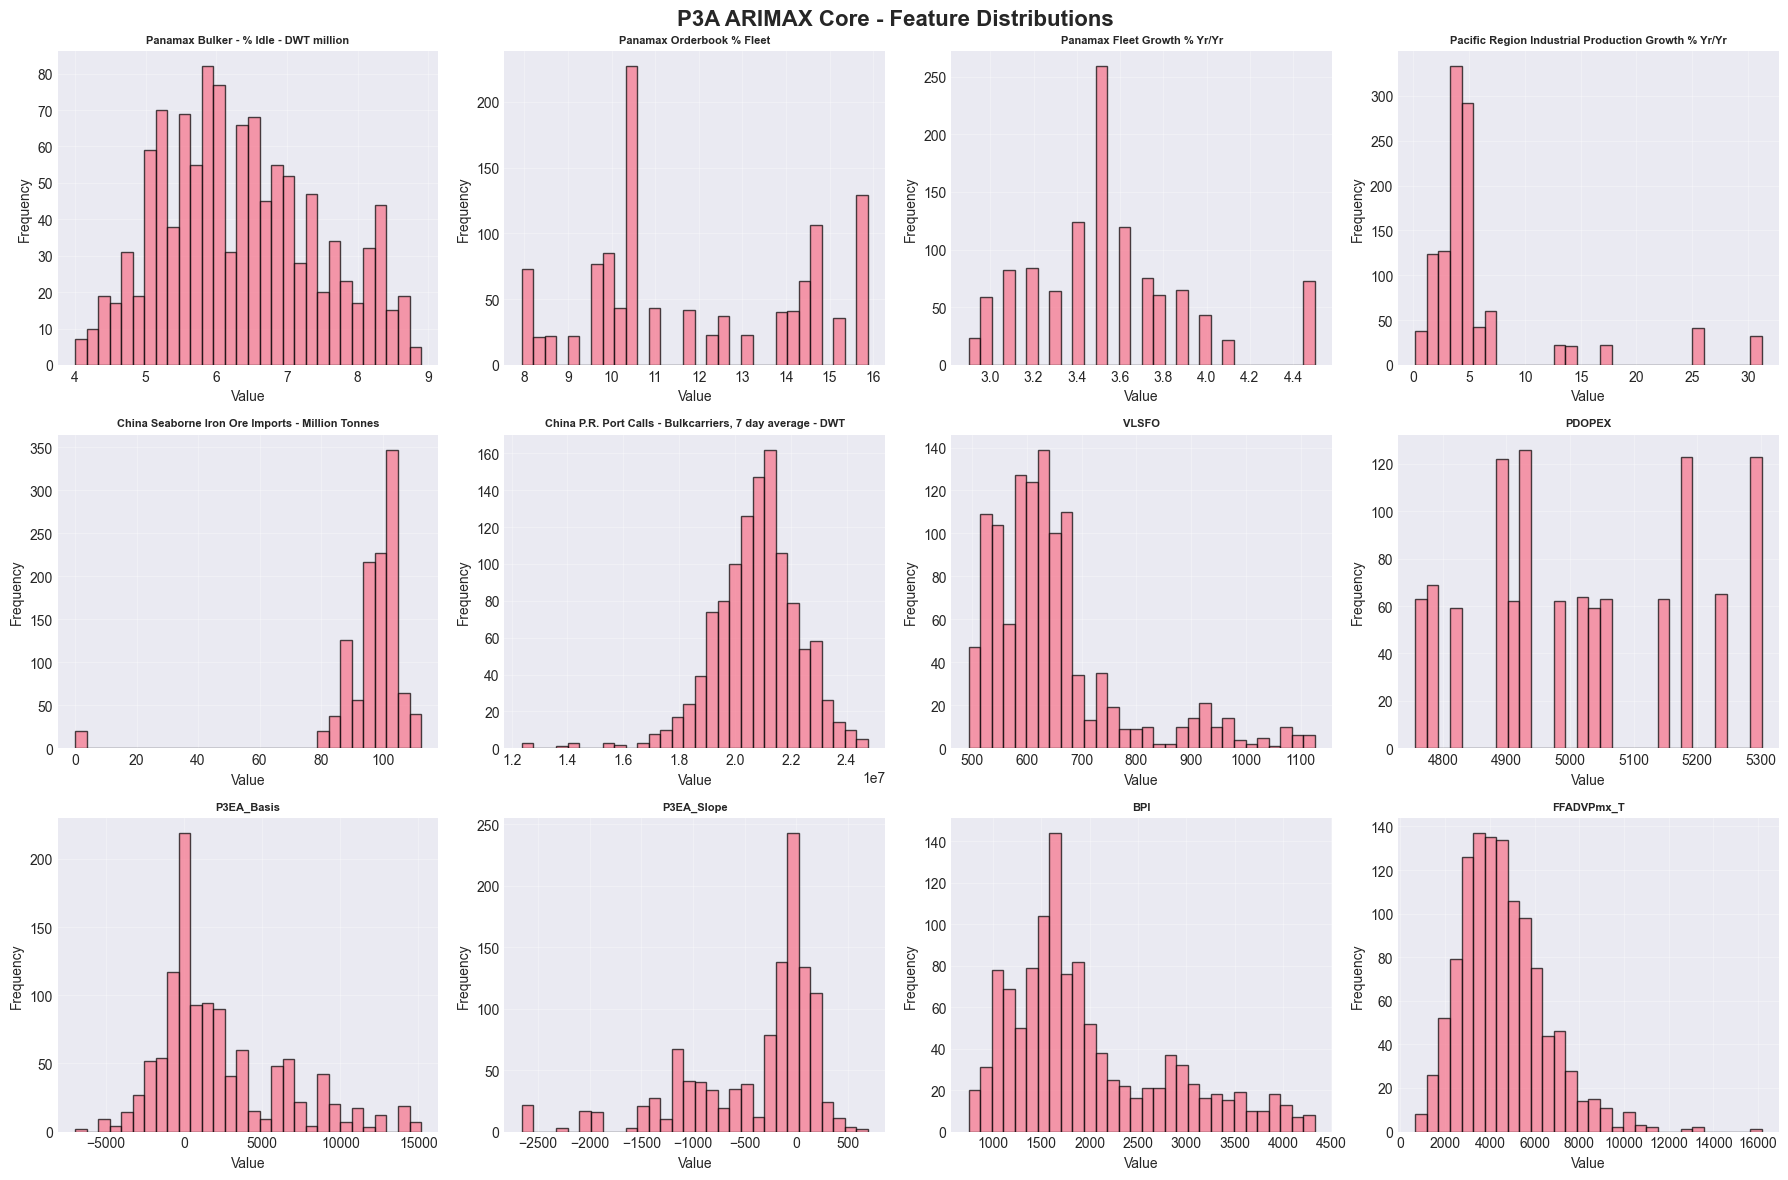

In [22]:
# Plot distributions of key features
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle('P1A ARIMAX Core - Feature Distributions', fontsize=16, fontweight='bold')

for idx, col in enumerate(p1a_arimax_core):
    ax = axes[idx // 4, idx % 4]
    ax.hist(p1a_arimax_df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(col, fontsize=8, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot distributions for P3A
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle('P3A ARIMAX Core - Feature Distributions', fontsize=16, fontweight='bold')

for idx, col in enumerate(p3a_arimax_core):
    ax = axes[idx // 4, idx % 4]
    ax.hist(p3a_arimax_df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(col, fontsize=8, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

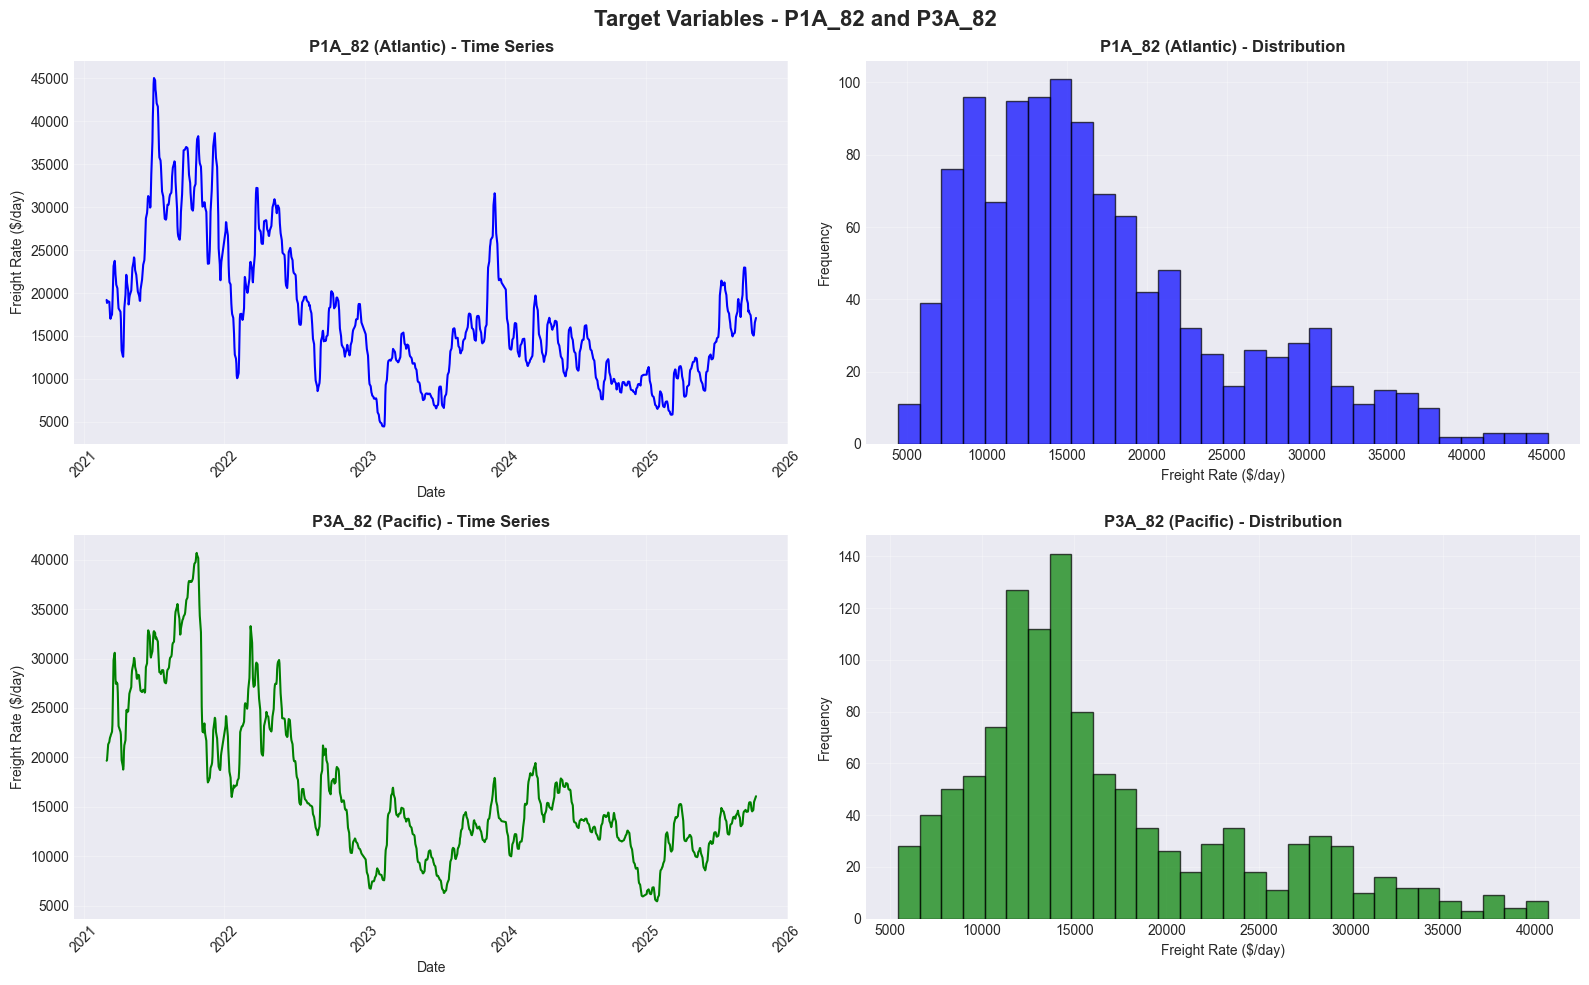


Target Variables Comparison:

P1A_82 (Atlantic):
count     1154.000000
mean     17151.163778
std       8093.448833
min       4458.000000
25%      11180.000000
50%      15229.000000
75%      21268.750000
max      45050.000000
Name: P1A_82, dtype: float64

P3A_82 (Pacific):
count     1154.000000
mean     16720.416811
std       7509.522620
min       5434.000000
25%      11669.000000
50%      14377.500000
75%      20269.750000
max      40687.000000
Name: P3A_82, dtype: float64

Correlation between P1A_82 and P3A_82: 0.850


In [23]:
# Plot target variables
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Target Variables - P1A_82 and P3A_82', fontsize=16, fontweight='bold')

# P1A_82 time series
axes[0, 0].plot(targets_clean['Date'], targets_clean['P1A_82'], linewidth=1.5, color='blue')
axes[0, 0].set_title('P1A_82 (Atlantic) - Time Series', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Freight Rate ($/day)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# P1A_82 distribution
axes[0, 1].hist(targets_clean['P1A_82'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[0, 1].set_title('P1A_82 (Atlantic) - Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Freight Rate ($/day)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# P3A_82 time series
axes[1, 0].plot(targets_clean['Date'], targets_clean['P3A_82'], linewidth=1.5, color='green')
axes[1, 0].set_title('P3A_82 (Pacific) - Time Series', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Freight Rate ($/day)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# P3A_82 distribution
axes[1, 1].hist(targets_clean['P3A_82'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_title('P3A_82 (Pacific) - Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Freight Rate ($/day)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare targets
print("\nTarget Variables Comparison:")
print("="*80)
print("\nP1A_82 (Atlantic):")
print(targets_clean['P1A_82'].describe())
print("\nP3A_82 (Pacific):")
print(targets_clean['P3A_82'].describe())
print(f"\nCorrelation between P1A_82 and P3A_82: {targets_clean['P1A_82'].corr(targets_clean['P3A_82']):.3f}")

In [24]:
print("\n" + "="*80)
print("SPRINT 2: FEATURE ENGINEERING & EDA - COMPLETION SUMMARY")
print("="*80)

print("\n1. DATA LOADED:")
print(f"   - Baltic Exchange: 20 features")
print(f"   - Bunker Prices: 2 features")
print(f"   - BFA Forward Contracts: 22 features")
print(f"   - Clarksons Daily: 6 features")
print(f"   - Clarksons Weekly: 7 features")
print(f"   - Clarksons Monthly: 25 features")
print(f"   - Total raw features: 80")

print("\n2. FEATURE ENGINEERING COMPLETED:")
print(f"   - BFA engineered features: 8 (4 per route)")
print(f"   - P1EA: Basis, Slope, Curvature, Contango")
print(f"   - P3EA: Basis, Slope, Curvature, Contango")
print(f"   - Total features after engineering: {80 - 22 + 8} features")

print("\n3. RA-LOCF APPLIED:")
print(f"   - Daily features: 0 days lag")
print(f"   - Weekly features: 0 days lag")
print(f"   - Monthly features: 15 days lag")
print(f"   - Clean dataset: {clean_df.shape[0]} rows, {clean_df.shape[1]} columns")

print("\n4. MODEL-READY DATASETS CREATED:")
print(f"   - p1a_ml_features.csv: {p1a_ml_df.shape[0]} rows × {p1a_ml_df.shape[1]-1} features")
print(f"   - p1a_arimax_core.csv: {p1a_arimax_df.shape[0]} rows × {p1a_arimax_df.shape[1]-1} features")
print(f"   - p3a_ml_features.csv: {p3a_ml_df.shape[0]} rows × {p3a_ml_df.shape[1]-1} features")
print(f"   - p3a_arimax_core.csv: {p3a_arimax_df.shape[0]} rows × {p3a_arimax_df.shape[1]-1} features")
print(f"   - targets.csv: {targets_clean.shape[0]} rows × 2 targets")
print(f"   - feature_metadata.csv: {len(all_features)} features documented")

print("\n5. EDA COMPLETED:")
print(f"   - Summary statistics computed")
print(f"   - Correlation analysis performed")
print(f"   - Stationarity testing (ADF & KPSS) completed")
print(f"   - Distribution analysis visualized")
print(f"   - Target variable analysis completed")

print("\n6. VALIDATION CHECKS:")
print(f"   - All datasets aligned on dates: {(p1a_ml_df['Date'] == p3a_ml_df['Date']).all()}")
print(f"   - No missing values in final datasets: {p1a_ml_df.isnull().sum().sum() == 0}")
print(f"   - Feature counts match specification: P1A ML={len(p1a_ml_features)}, P1A ARIMAX={len(p1a_arimax_core)}, P3A ML={len(p3a_ml_features)}, P3A ARIMAX={len(p3a_arimax_core)}")

print("\n" + "="*80)
print("Sprint 2 successfully completed! Ready for Sprint 3 (Modeling).")
print("="*80)


SPRINT 2: FEATURE ENGINEERING & EDA - COMPLETION SUMMARY

1. DATA LOADED:
   - Baltic Exchange: 20 features
   - Bunker Prices: 2 features
   - BFA Forward Contracts: 22 features
   - Clarksons Daily: 6 features
   - Clarksons Weekly: 7 features
   - Clarksons Monthly: 25 features
   - Total raw features: 80

2. FEATURE ENGINEERING COMPLETED:
   - BFA engineered features: 8 (4 per route)
   - P1EA: Basis, Slope, Curvature, Contango
   - P3EA: Basis, Slope, Curvature, Contango
   - Total features after engineering: 66 features

3. RA-LOCF APPLIED:
   - Daily features: 0 days lag
   - Weekly features: 0 days lag
   - Monthly features: 15 days lag
   - Clean dataset: 1154 rows, 68 columns

4. MODEL-READY DATASETS CREATED:
   - p1a_ml_features.csv: 1154 rows × 49 features
   - p1a_arimax_core.csv: 1154 rows × 12 features
   - p3a_ml_features.csv: 1154 rows × 57 features
   - p3a_arimax_core.csv: 1154 rows × 12 features
   - targets.csv: 1154 rows × 2 targets
   - feature_metadata.csv: 67 